# Libraries

In [2]:
import os
import warnings
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from urllib.parse import urlparse
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn
from wordcloud import WordCloud, STOPWORDS
import string

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

mlflow.autolog()



sys.path.append(str(Path.cwd().parent))
""" from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            ) """

2023/08/20 19:30:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


' from settings.params import (DATA_DIR_INPUT,\n                             DATA_DIR_OUTPUT,\n                             MODEL_PARAMS,\n                             REPORT_DIR,\n                             TIMEZONE,\n                            ) '

# Dataset

In [3]:
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data\sample_submission.csv
../data\test.csv
../data\train.csv


In [4]:
data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
data.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [8]:
data.shape

(7613, 5)

In [9]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# Data Visualization

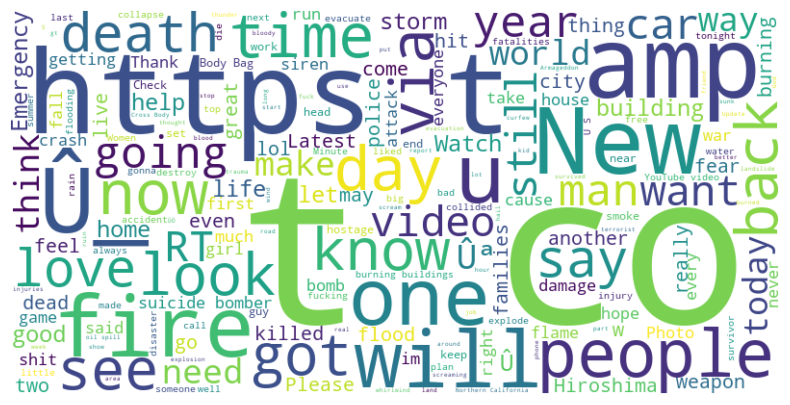

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_text = " ".join(text for text in data["text"])

# Générer un word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

#  Affichage du wordcloud en utilisant matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Target Variable Distribution

The target values denote whether a tweet is about a real disaster (1) or not (0)

In [17]:
x=data.target.value_counts()
x

target
0    4342
1    3271
Name: count, dtype: int64

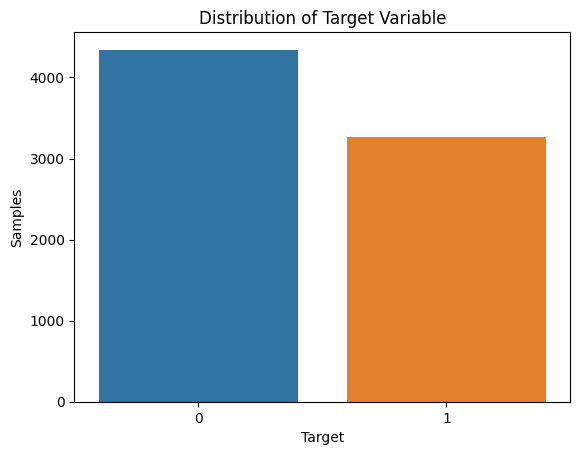

In [18]:
x = data["target"].value_counts()


sns.barplot(x=x.index, y=x)
plt.ylabel('Samples')
plt.xlabel('Target')
plt.title('Distribution of Target Variable')
plt.show()



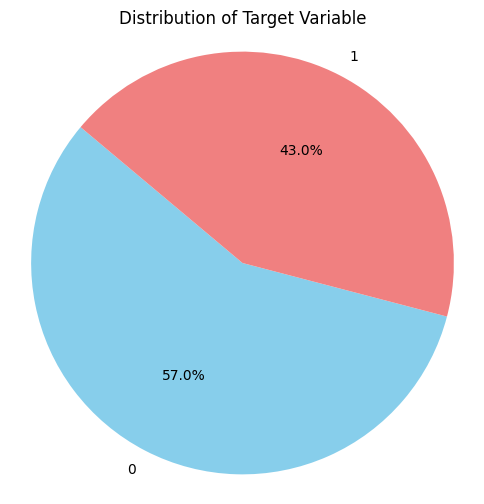

In [19]:
plt.figure(figsize=(6, 6))
plt.pie(x, labels=x.index, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightcoral"])
plt.title('Distribution of Target Variable')
plt.axis("equal")  
plt.show()

### The distribution of the target variable based on different keywords in the DataFrame

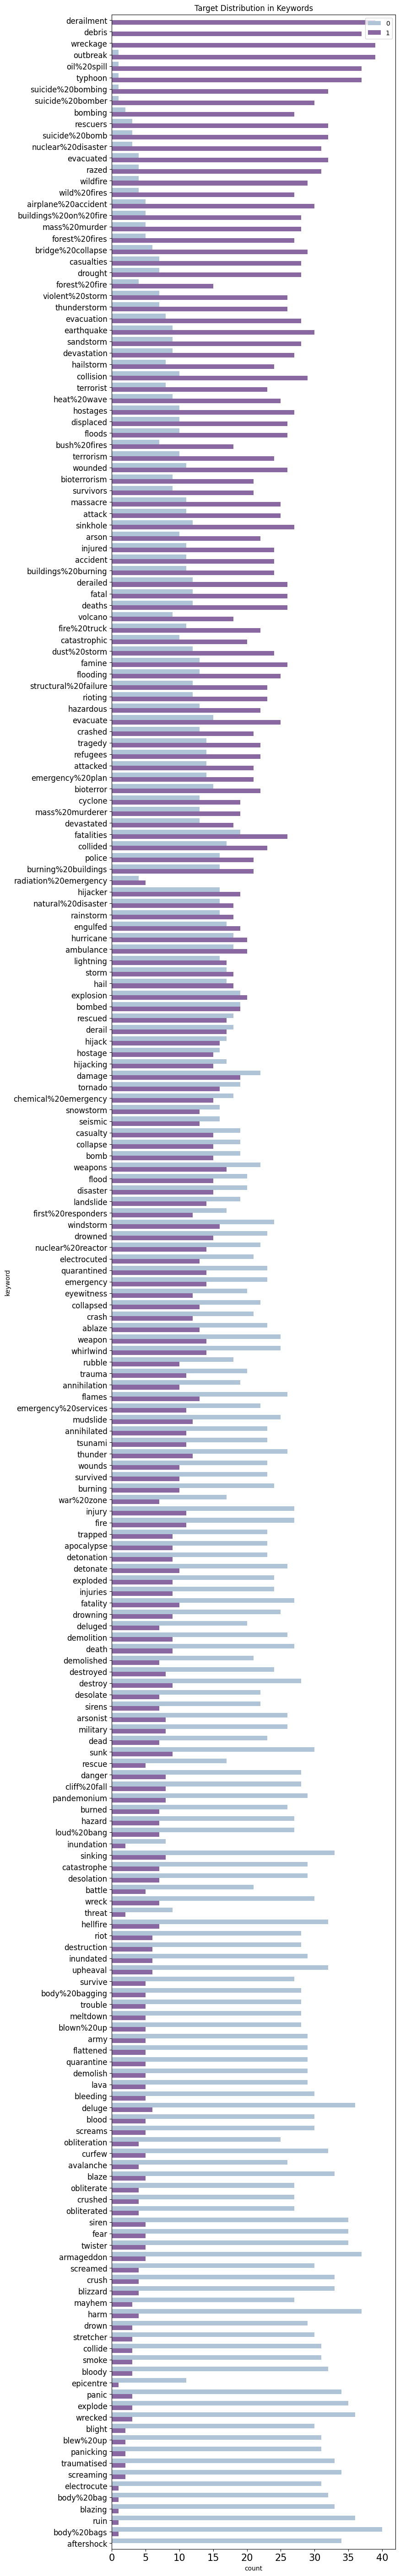

In [20]:

# Calculate the mean target value for each keyword
data['target_mean'] = data.groupby('keyword')['target'].transform('mean')

# Sort the DataFrame by target_mean in descending order
data_sorted = data.sort_values(by='target_mean', ascending=False)

# Create the figure and plot
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(
    y=data_sorted['keyword'],
    hue=data_sorted['target'],
    palette="BuPu"
)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()

# Drop the temporary 'target_mean' column
data.drop(columns=['target_mean'], inplace=True)


### The top 15 keywords based on their frequencies in the DataFrame

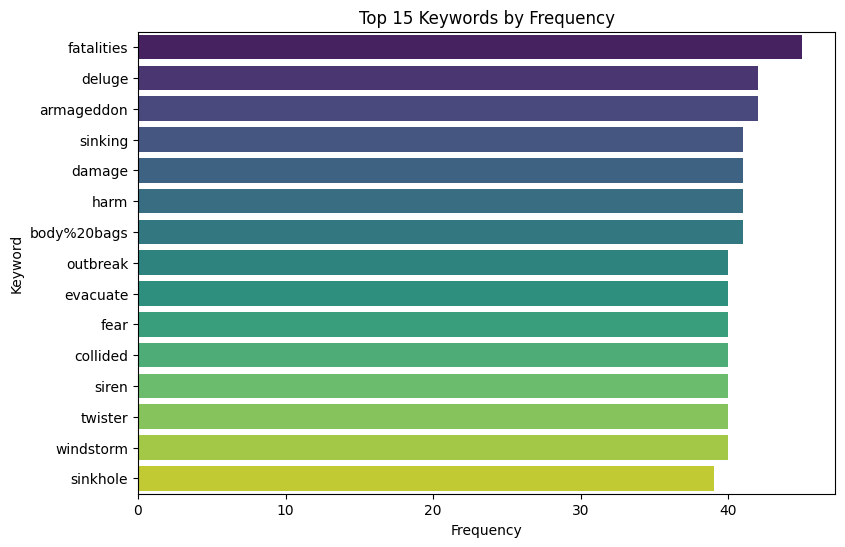

In [21]:
plt.figure(figsize=(9, 6))
sns.countplot(
    y=data['keyword'],
    order=data['keyword'].value_counts().iloc[:15].index,
    palette="viridis"  # You can customize the color palette if desired
)
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 15 Keywords by Frequency')
plt.show()


# Data Preprocessing

In [24]:
data.dtypes

id                 int64
keyword           object
location          object
text              object
target             int64
tokenized_text    object
dtype: object

In [25]:
data.isna().sum()

id                   0
keyword             61
location          2533
text                 0
target               0
tokenized_text       0
dtype: int64

## Data Tokenisation

In [23]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # Téléchargement des données nécessaires pour la tokenisation


text_column = 'text'  


data['tokenized_text'] = data[text_column].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polytech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Suppression des stopwords

In [27]:
from nltk.corpus import stopwords

tokenized_text_column = 'tokenized_text'  

# Obtenir la liste des stopwords
stop_words = set(stopwords.words('english')) 

# Appliquer la suppression des stopwords à chaque liste de tokens dans la colonne
data['cleaned_text'] = data[tokenized_text_column].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

print(data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polytech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
data['cleaned_text']

0       [Deeds, Reason, #, earthquake, May, ALLAH, For...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [residents, asked, 'shelter, place, ', notifie...
3       [13,000, people, receive, #, wildfires, evacua...
4       [got, sent, photo, Ruby, #, Alaska, smoke, #, ...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [@, aria_ahrary, @, TheTawniest, control, wild...
7610    [M1.94, [, 01:04, UTC, ], ?, 5km, Volcano, Haw...
7611    [Police, investigating, e-bike, collided, car,...
7612    [Latest, :, Homes, Razed, Northern, California...
Name: cleaned_text, Length: 7613, dtype: object

## Stemming des données 
Le stemming est le processus de réduction des mots à leur forme de base ou racine, ce qui permet de regrouper différentes formes d'un même mot ensemble. Par exemple, les mots "running", "ran" et "runs" seraient réduits à la racine "run".

# Modèles à tester:

In [29]:
from nltk.stem import PorterStemmer

cleaned_text_column = 'cleaned_text'  

# Instancier le stemmer de Porter
stemmer = PorterStemmer()

# Appliquer le stemming à chaque liste de mots dans la colonne
data['stemmed_text'] = data[cleaned_text_column].apply(lambda words: [stemmer.stem(word) for word in words])

print(data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 

In [30]:
data['cleaned_text']

0       [Deeds, Reason, #, earthquake, May, ALLAH, For...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [residents, asked, 'shelter, place, ', notifie...
3       [13,000, people, receive, #, wildfires, evacua...
4       [got, sent, photo, Ruby, #, Alaska, smoke, #, ...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [@, aria_ahrary, @, TheTawniest, control, wild...
7610    [M1.94, [, 01:04, UTC, ], ?, 5km, Volcano, Haw...
7611    [Police, investigating, e-bike, collided, car,...
7612    [Latest, :, Homes, Razed, Northern, California...
Name: cleaned_text, Length: 7613, dtype: object

# Entrainement des modeles

In [31]:
def define_pipeline(numeric_transformer,
                   categorical_transformer,
                   **kwargs):
    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),])
    model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model_name", kwargs.get('model_name'))]
    )
    return model

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def define_pipeline(numeric_transformer, categorical_transformer, model_name, numerical_features, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    model = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model_name)]
    )
    return model


numerical_features = ['numerical_column1', 'numerical_column2', ...]  
categorical_features = ['categorical_column1', 'categorical_column2', ...]  

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="undefined"),
    OneHotEncoder(handle_unknown="ignore")
)

model_name = RandomForestClassifier(random_state=42)  # Utilisez RandomForestClassifier

## RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

pipeline1 = define_pipeline(numeric_transformer, categorical_transformer, RandomForestClassifier, numerical_features, categorical_features)
pipeline1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.ensemble._forest.RandomForestClassifier'>)])

## K-Nearest Neighbors (K-NN)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

pipeline2 = define_pipeline(numeric_transformer, categorical_transformer, KNeighborsClassifier, numerical_features, categorical_features)
pipeline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.neighbors._classification.KNeighborsClassifier'>)])

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

pipeline3 = define_pipeline(numeric_transformer, categorical_transformer, LogisticRegression, numerical_features, categorical_features)
pipeline3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.linear_model._logistic.LogisticRegression'>)])

## Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB  # For Multinomial Naive Bayes

pipeline4 = define_pipeline(numeric_transformer, categorical_transformer, MultinomialNB, numerical_features, categorical_features)
pipeline4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model', <class 'sklearn.naive_bayes.MultinomialNB'>)])